# brain_age

Predict age from brain grey matter (regression).
Aging is associated with is grey matter (GM) atrophy, each year, an adult lose
0.1% of GM. We will try to learn a predictor of the chronological age (true age)
using GM measurements on the brain on a population of healthy control participants.

Such a predictor provides the expected **brain age** of a subject. Deviation from
this expected brain age indicates acceleration or slowdown of the aging process
which may be associated with a pathological neurobiological process or protective factor of aging.

## Dataset

There are 357 samples in the training set and 90 samples in the test set.

### Input data

Voxel-based_morphometry [VBM](https://en.wikipedia.org/wiki/Voxel-based_morphometry)
using [cat12](http://www.neuro.uni-jena.de/cat/) software which provides:

- Regions Of Interest (`rois`) of Grey Matter (GM) scaled for the Total
  Intracranial Volume (TIV): `[train|test]_rois.csv` 284 features.

- VBM GM 3D maps or images (`vbm3d`) of [voxels](https://en.wikipedia.org/wiki/Voxel) in the
  [MNI](https://en.wikipedia.org/wiki/Talairach_coordinates) space:
  `[train|test]_vbm.npz` contains 3D images of shapes (121, 145, 121).
  This npz contains the 3D mask and the affine transformation to MNI
  referential. Masking the brain provide *flat* 331 695 input features (voxels)
  for each participant.

By default `problem.get_[train|test]_data()` return the concatenation of 284 ROIs of
Grey Matter (GM) features with 331 695 features (voxels) within a brain mask.
Those two blocks are higly redundant.
To select only on ROIs (`rois`) features do:

```
X[:, :284]
```

To select only on (`vbm`) (voxel with the brain) features do:

```
X[:, 284:]
```

### Target

The target can be found in `[test|train]_participants.csv` files, selecting the
`age` column for regression problem.

## Evaluation metrics

[sklearn metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)

The main Evaluation metrics is the Root-mean-square deviation
[RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation). We will also
look at the R-squared
[R2](https://en.wikipedia.org/wiki/Coefficient_of_determination).


## Links


- [RAMP-workflow’s documentation](https://paris-saclay-cds.github.io/ramp-workflow/)
- [RAMP-workflow’s github](https://github.com/paris-saclay-cds/ramp-workflow)
- [RAMP Kits](https://github.com/ramp-kits)

## Installation

This starting kit requires Python and the following dependencies:

* `numpy`
* `scipy`
* `pandas`
* `scikit-learn`
* `matplolib`
* `seaborn`
* `jupyter`
* `ramp-workflow`

Therefore, we advise you to install [Anaconda
distribution](https://www.anaconda.com/download/) which include almost all
dependencies.

Only `nilearn` and `ramp-workflow` are not included by default in the Anaconda
distribution. They will be installed from the execution of the notebook.

To run a submission and the notebook you will need the dependencies listed in requirements.txt.
You can install the dependencies with the following command-line:

```
pip install -U -r requirements.txt
```

If you are using conda, we provide an environment.yml file for similar usage.

```
conda env create -f environment.yml
```

Then, you can activate the environment using:

```
conda activate brain_age
```

And desactivate using

```
conda deactivate
```

## Getting started

1. Download the data locally:

```
python download_data.py
```

2. Execute the jupyter notebook, from the root directory using:

```
jupyter notebook brain_age_starting_kit.ipynb
```

Tune your model using the starting_kit

3. Submission (Run locally)

The submissions need to be located in the `submissions` folder.
For instance for `starting_kit`, it should be located in
`submissions/submissions/starting_kit`.

Copy everything required to build your estimator in a submission file:
`submissions/submissions/starting_kit/estimator.py`.
This file must contain a function `get_estimator()`.

Run locally:

```
ramp-test --submission starting_kit
```

4. Submission on RAMP:

[Using RAMP starting-kits](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html)

## Descriptive statistics

age                                                         \
       count       mean        std        min        25%        50%   
set                                                                   
test    90.0  47.848019  17.852717  20.071184  31.819986  44.855578   
train  357.0  49.138846  16.095719  19.980835  35.455168  50.902122   

                             
             75%        max  
set                          
test   62.017112  82.187543  
train  62.061602  86.318960

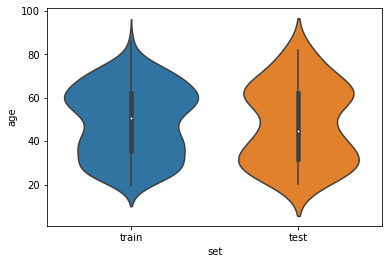

In [1]:
%matplotlib inline
#test
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

participants_train = pd.read_csv(os.path.join("data", "train_participants.csv" ))
participants_train["set"] = 'train'
participants_test = pd.read_csv(os.path.join("data", "test_participants.csv" ))
participants_test["set"] = 'test'
participants = participants_train.append(participants_test)

sns.violinplot(x="set", y="age", data=participants)
participants[["age", "set"]].groupby("set").describe()

## Unsupervized analysis: Explore main sources of variabilities


Load ROIs data

In [2]:
globvol_rois_train = pd.read_csv(os.path.join("data", "train_rois.csv"))
print(globvol_rois_train.iloc[:5, :10])

   participant_id     CSF_Vol      GM_Vol      WM_Vol  l3thVen_GM_Vol  \
0             651  334.031002  603.083565  560.465707        0.046239   
1             431  300.991328  603.101354  594.425495        0.052599   
2             398  252.410342  641.965684  604.320324        0.063052   
3             419  402.533442  604.978032  490.709738        0.043962   
4             627  409.460047  579.029937  509.311974        0.042226   

   r3thVen_GM_Vol  l4thVen_GM_Vol  r4thVen_GM_Vol  lAcc_GM_Vol  rAcc_GM_Vol  
0        0.052240        0.063827        0.068097     0.419533     0.427702  
1        0.047901        0.088186        0.105241     0.373451     0.377817  
2        0.051575        0.083113        0.076834     0.447264     0.465415  
3        0.041684        0.089264        0.083791     0.391540     0.388656  
4        0.036072        0.073829        0.081725     0.339043     0.358513  


`train_rois.csv` provides:

- Global volumes of "tissues": CerrebroSpinal Fluid (`CSF_Vol`), Grey (`GM_Vol`) and White Matter (`WM_Vol`) volume of participants.
- ROIs are starting at column `l3thVen_GM_Vol`. Note that `rois_train.loc[:, 'l3thVen_GM_Vol':]` matches `problem.get_train_data()[:, :284]`.

In [3]:
rois_train = globvol_rois_train.loc[:, 'l3thVen_GM_Vol':]
vols_train = globvol_rois_train.loc[:, ['CSF_Vol', 'GM_Vol', 'WM_Vol']]

### PCA on ROIs: explore global effect of age

In [4]:
from sklearn.decomposition import PCA

pca_rois = PCA(n_components=2)
PCs_rois = pca_rois.fit_transform(rois_train)
print(pca_rois.explained_variance_ratio_)

df = pd.DataFrame(dict(age=participants_train['age'], PC1_ROIs=PCs_rois[:, 0], PC2_ROIs=PCs_rois[:, 1]))

[0.54771351 0.10711543]


Main sources of variability ?


               age      PC1_ROIs      PC2_ROIs
age       1.000000  8.177015e-01 -1.108805e-01
PC1_ROIs  0.817702  1.000000e+00 -4.453472e-18
PC2_ROIs -0.110881 -4.453472e-18  1.000000e+00


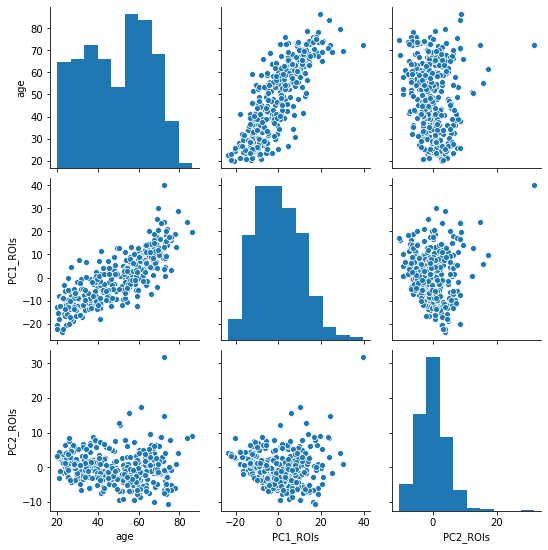

In [5]:
sns.pairplot(df)
print(df.corr())

### Neurobiological effect of age

PC1_ROIs is higlhy correlated with age Thus age seems to be the main source of variability.

Question: what is Neurobiological effect of age ? Lets explore the hypothesis of brain atrophy.

We compute brain atrophy indices:

- GM_ratio: GM_Vol / (GM_Vol + WM_Vol + CSF_Vol). It is ratio of GM in the brain.
- WM_ratio: WM_Vol / (GM_Vol + WM_Vol + CSF_Vol). It is ratio of WM in the brain.

           PC1_ROIs       age  GM_ratio  WM_ratio  CSF_ratio
PC1_ROIs   1.000000  0.817702 -0.944958 -0.467386   0.960228
age        0.817702  1.000000 -0.818380 -0.345080   0.803764
GM_ratio  -0.944958 -0.818380  1.000000  0.225909  -0.890849
WM_ratio  -0.467386 -0.345080  0.225909  1.000000  -0.643805
CSF_ratio  0.960228  0.803764 -0.890849 -0.643805   1.000000


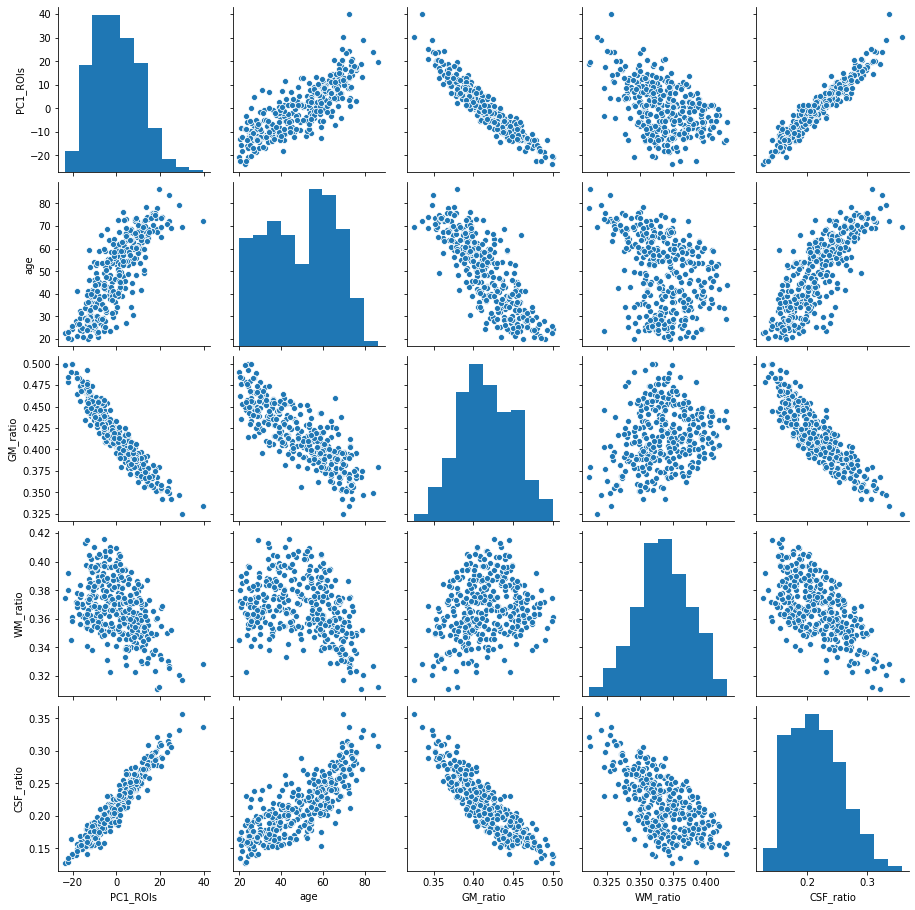

In [6]:
df["GM_ratio"] = vols_train.loc[:, "GM_Vol"] / vols_train.sum(axis=1)
df["WM_ratio"] = vols_train.loc[:, "WM_Vol"] / vols_train.sum(axis=1)
df["CSF_ratio"] = vols_train.loc[:, "CSF_Vol"] / vols_train.sum(axis=1)

sns.pairplot(df[["PC1_ROIs", "age", "GM_ratio", "WM_ratio","CSF_ratio"]])
print(df[["PC1_ROIs", "age", "GM_ratio", "WM_ratio", "CSF_ratio"]].corr())

Very strong effect on GM:
- GM_ratio correlate with PC1_ROIs
- GM_ratio correlate with age

Effect on WM:
- WM_ratio correlate with PC1_ROIs
- WM_ratio correlate with age


Aging (strongly correlates with PC1) and leads to decrease of GM_ratio and increase of CSF_ratio:

### Conclusion

**Aging leads to brain atrophy with is the main source of brain variability.
Therefore it should be possible to predict the age form the brain anatomy.**

## Machine learning


Import and read data

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics
import problem

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [3]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

assert X_train.shape[1] == 284 + 331695

## Utils functions

Function to compute scores

In [4]:
def cv_train_test_scores(rmse_cv_test, rmse_cv_train, r2_cv_test, r2_cv_train,
                         y_train, y_pred_train, y_test, y_pred_test):
    """Compute CV score, train and test score from a cv grid search model.

    Parameters
    ----------
    rmse_cv_test : array
        Test rmse across CV folds.
    rmse_cv_train : array
        Train rmse across CV folds.

    r2_cv_test : array
        Test R2 across CV folds.
    r2_cv_train : array
        Train R2 across CV folds.

    y_train : array
        True train values.
    y_pred_train : array
        Predicted train values.
    y_test : array
        True test values.
    y_pred_test : array
        Predicted test values.

    Returns
    -------
    info : TYPE
        DataFrame(r2_cv, r2_train, mae_train, mse_train).
    """
    # CV scores
    rmse_cv_test_mean, rmse_cv_test_sd = np.mean(rmse_cv_test), np.std(rmse_cv_test)
    rmse_cv_train_mean, rmse_cv_train_sd = np.mean(rmse_cv_train), np.std(rmse_cv_train)

    r2_cv_test_mean, r2_cv_test_sd = np.mean(r2_cv_test), np.std(r2_cv_test)
    r2_cv_train_mean, r2_cv_train_sd = np.mean(r2_cv_train), np.std(r2_cv_train)

    # Test scores
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    r2_test = metrics.r2_score(y_test, y_pred_test)

    # Train scores
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    r2_train = metrics.r2_score(y_train, y_pred_train)

    
    scores = pd.DataFrame([[rmse_cv_test_mean, rmse_cv_test_sd, rmse_cv_train_mean, rmse_cv_train_sd,
                            r2_cv_test_mean, rmse_cv_test_sd, r2_cv_train_mean, r2_cv_train_sd,
                            rmse_test, r2_test, rmse_train, r2_train
                           ]],
                        columns=('rmse_cv_test_mean', 'rmse_cv_test_sd', 'rmse_cv_train_mean', 'rmse_cv_train_sd',
                                 'r2_cv_test_mean', 'rmse_cv_test_sd', 'r2_cv_train_mean', 'r2_cv_train_sd',
                                 'rmse_test', 'r2_test', 'rmse_train', 'r2_train'
                                 ))

    return scores

## Feature extractor of ROIs or voxels within the brain (VBM)

Selecting only rois or vbm images:

This can be achieved by a `ROIsFeatureExtractor` or `VBMFeatureExtractor` 

In [5]:
class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]

class VBMFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, 284:]


fe = ROIsFeatureExtractor()
print(fe.transform(X_train).shape)

fe = VBMFeatureExtractor()
print(fe.transform(X_train).shape)

(357, 284)
(357, 331695)


## Design of predictors and their evaluation using CV and test set

The framework is evaluated with a cross-validation approach. The metrics used are the root-mean-square error (RMSE).

First we propose a simple Regression predictor based on ROIs features only:

In [6]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), LinearRegression())

cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.4min finished


Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,47.793
rmse_cv_test_sd,16.807
rmse_cv_train_mean,0.639
rmse_cv_train_sd,0.288
r2_cv_test_mean,-8.540
rmse_cv_test_sd,16.807
r2_cv_train_mean,0.998
r2_cv_train_sd,0.002
rmse_test,14.338
r2_test,0.348


In [18]:
from sklearn.neural_network import MLPRegressor

cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), MLPRegressor(alpha = 2000,hidden_layer_sizes=(500, 300,200)))

cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.4min finished
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,7.442
rmse_cv_test_sd,0.591
rmse_cv_train_mean,5.318
rmse_cv_train_sd,0.050
r2_cv_test_mean,0.780
rmse_cv_test_sd,0.591
r2_cv_train_mean,0.890
r2_cv_train_sd,0.002
rmse_test,6.712
r2_test,0.857


In [10]:
from sklearn.cross_decomposition import PLSRegression

cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), PLSRegression(n_components=4))

cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.2min finished


Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,7.446
rmse_cv_test_sd,0.257
rmse_cv_train_mean,5.476
rmse_cv_train_sd,0.050
r2_cv_test_mean,0.781
rmse_cv_test_sd,0.257
r2_cv_train_mean,0.884
r2_cv_train_sd,0.004
rmse_test,8.500
r2_test,0.771


In [21]:
from sklearn import ensemble

gbr = ensemble.GradientBoostingRegressor(n_estimators= 1000, max_depth= 4, min_samples_split= 3, learning_rate= 0.1, max_features = 70)

cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), gbr)

cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.1min finished


Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,8.208
rmse_cv_test_sd,0.658
rmse_cv_train_mean,0.000
rmse_cv_train_sd,0.000
r2_cv_test_mean,0.735
rmse_cv_test_sd,0.658
r2_cv_train_mean,1.000
r2_cv_train_sd,0.000
rmse_test,7.152
r2_test,0.838


In [ ]:
cv = problem.get_cv(X_train, y_train)


estimator = make_pipeline(VBMFeatureExtractor(), StandardScaler(), Ridge(alpha=10))

cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [27]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), Lasso(alpha=0.15))

cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.4min finished


Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,7.296
rmse_cv_test_sd,0.520
rmse_cv_train_mean,4.630
rmse_cv_train_sd,0.051
r2_cv_test_mean,0.788
rmse_cv_test_sd,0.520
r2_cv_train_mean,0.917
r2_cv_train_sd,0.003
rmse_test,6.072
r2_test,0.883


In [14]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), Lasso(alpha=0.1))

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
r2_train = metrics.r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
r2_test = metrics.r2_score(y_test, y_pred_test)

print('rmse_train',rmse_train)
print('r2_train',r2_train)

print('rmse_test',rmse_test)
print('r2_test',r2_test)


rmse_train 4.608346306170313
r2_train 0.9177969977925321
rmse_test 6.063458290375889
r2_test 0.8833500269176434


In [23]:
from sklearn import svm


estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), svm.SVR(kernel = 'rbf',gamma = 0.001, C = 75, epsilon = 0.72))

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
r2_train = metrics.r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
r2_test = metrics.r2_score(y_test, y_pred_test)

print('rmse_train',rmse_train)
print('r2_train',r2_train)

print('rmse_test',rmse_test)
print('r2_test',r2_test)


rmse_train 2.6413081850777584
r2_train 0.9729955325043806
rmse_test 5.591458605033239
r2_test 0.9008040177793041


In [16]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), Lasso(alpha=0.001))

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
r2_train = metrics.r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
r2_test = metrics.r2_score(y_test, y_pred_test)

print('rmse_train',rmse_train)
print('r2_train',r2_train)

print('rmse_test',rmse_test)
print('r2_test',r2_test)

rmse_train 2.6762774907068514
r2_train 0.9722757538418062
rmse_test 13.74588987041584
r2_test 0.4004994661489282


C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 716.8218959182731, tolerance: 9.22296908057713
  model = cd_fast.enet_coordinate_descent(


In [18]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), Lasso(alpha=0.00001))

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
r2_train = metrics.r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
r2_test = metrics.r2_score(y_test, y_pred_test)

print('rmse_train',rmse_train)
print('r2_train',r2_train)

print('rmse_test',rmse_test)
print('r2_test',r2_test)

rmse_train 2.664400208800567
r2_train 0.9725212874227722
rmse_test 14.516972862081145
r2_test 0.3313544110729477


C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1262.077145450488, tolerance: 9.22296908057713
  model = cd_fast.enet_coordinate_descent(


In [13]:
cv = problem.get_cv(X_train, y_train)
print(cv)

<generator object _BaseKFold.split at 0x00000194B4443190>


In [19]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), Lasso(alpha=1))

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
r2_train = metrics.r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
r2_test = metrics.r2_score(y_test, y_pred_test)

print('rmse_train',rmse_train)
print('r2_train',r2_train)

print('rmse_test',rmse_test)
print('r2_test',r2_test)

rmse_train 7.154514387845513
r2_train 0.8018665571000841
rmse_test 7.887595229964193
r2_test 0.8026063919483574


In [20]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), Lasso(alpha=10))

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
r2_train = metrics.r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
r2_test = metrics.r2_score(y_test, y_pred_test)

print('rmse_train',rmse_train)
print('r2_train',r2_train)

print('rmse_test',rmse_test)
print('r2_test',r2_test)

rmse_train 14.49069192091013
r2_train 0.18721494420220008
rmse_test 16.035009660986898
r2_test 0.18420262072860794


In [21]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), Lasso(alpha=100))

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
r2_train = metrics.r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
r2_test = metrics.r2_score(y_test, y_pred_test)

print('rmse_train',rmse_train)
print('r2_train',r2_train)

print('rmse_test',rmse_test)
print('r2_test',r2_test)

rmse_train 16.073160014300168
r2_train 0.0
rmse_test 17.80012407917294
r2_test -0.005286645434799064


In [23]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), Lasso(alpha=10000))

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
r2_train = metrics.r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
r2_test = metrics.r2_score(y_test, y_pred_test)

print('rmse_train',rmse_train)
print('r2_train',r2_train)

print('rmse_test',rmse_test)
print('r2_test',r2_test)

rmse_train 16.073160014300168
r2_train 0.0
rmse_test 17.80012407917294
r2_test -0.005286645434799064


In [6]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), ElasticNet(alpha=1, l1_ratio = 0.1))

cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.3min finished


Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,7.356
rmse_cv_test_sd,0.380
rmse_cv_train_mean,5.983
rmse_cv_train_sd,0.064
r2_cv_test_mean,0.787
rmse_cv_test_sd,0.380
r2_cv_train_mean,0.861
r2_cv_train_sd,0.003
rmse_test,7.204
r2_test,0.835


In [ ]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(VBMFeatureExtractor(), StandardScaler(), ElasticNet(alpha=1, l1_ratio = 0.1))

cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {'lasso__alpha': 10. ** np.arange(-3, 3)}

model = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), Lasso(max_iter=1000))

estimator = GridSearchCV(model, param_grid, cv=5)

estimator.fit(X_train, y_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
print(estimator.best_params_)
print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351.4175908570314, tolerance: 7.229539823273881
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322.707125995016, tolerance: 7.436294028089312
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290.74161103317397, tolerance: 7.443605294259318
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklear

{'lasso__alpha': 0.1}
Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,7.401
rmse_cv_test_sd,0.386
rmse_cv_train_mean,4.171
rmse_cv_train_sd,0.099
r2_cv_test_mean,0.783
rmse_cv_test_sd,0.386
r2_cv_train_mean,0.933
r2_cv_train_sd,0.003
rmse_test,6.063
r2_test,0.883


In [18]:
a = estimator.best_estimator_.named_steps['lasso'].coef_
b = a[a!=0]
print(len(b))

122


In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {'lasso__alpha': 10. ** np.arange(-3, 3)}

model = make_pipeline(VBMFeatureExtractor(), StandardScaler(), Lasso(max_iter=1000))

estimator = GridSearchCV(model, param_grid, cv=5)

estimator.fit(X_train, y_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
print(estimator.best_params_)
print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.004259427476704, tolerance: 7.229539823273881
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.151625964408126, tolerance: 7.436294028089312
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.50109820659585, tolerance: 7.443605294259318
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\skle

{'lasso__alpha': 0.1}
Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,7.401
rmse_cv_test_sd,0.386
rmse_cv_train_mean,4.171
rmse_cv_train_sd,0.099
r2_cv_test_mean,0.783
rmse_cv_test_sd,0.386
r2_cv_train_mean,0.933
r2_cv_train_sd,0.003
rmse_test,6.912
r2_test,0.848


In [28]:
a = estimator.best_estimator_.named_steps['lasso'].coef_
b = a[a!=0]
print(len(b))

330


In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': 10. ** np.arange(-3, 5)}

model = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), Ridge(max_iter=1000))

estimator = GridSearchCV(model, param_grid, cv=5)

estimator.fit(X_train, y_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
print(estimator.best_params_)
print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

{'ridge__alpha': 100.0}
Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,47.793
rmse_cv_test_sd,16.807
rmse_cv_train_mean,0.639
rmse_cv_train_sd,0.288
r2_cv_test_mean,-8.540
rmse_cv_test_sd,16.807
r2_cv_train_mean,0.998
r2_cv_train_sd,0.002
rmse_test,6.682
r2_test,0.858


In [8]:
a = estimator.best_estimator_.named_steps['ridge'].coef_
b = a[a!=0]
print(len(b))

280


In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': 10. ** np.arange(-5, 5)}

model = make_pipeline(VBMFeatureExtractor(), StandardScaler(), Ridge(max_iter=1000))

estimator = GridSearchCV(model, param_grid, cv=5)

estimator.fit(X_train, y_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
print(estimator.best_params_)
print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

{'ridge__alpha': 1e-05}
Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,47.793
rmse_cv_test_sd,16.807
rmse_cv_train_mean,0.639
rmse_cv_train_sd,0.288
r2_cv_test_mean,-8.540
rmse_cv_test_sd,16.807
r2_cv_train_mean,0.998
r2_cv_train_sd,0.002
rmse_test,6.784
r2_test,0.854


In [11]:
a = estimator.best_estimator_.named_steps['ridge'].coef_
b = a[a!=0]
print(len(b))

331695


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': 10. ** np.arange(2, 5)}

model = make_pipeline(VBMFeatureExtractor(), StandardScaler(), Ridge(max_iter=1000))

estimator = GridSearchCV(model, param_grid, cv=5)

estimator.fit(X_train, y_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
print(estimator.best_params_)
print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

{'ridge__alpha': 100.0}
Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,47.793
rmse_cv_test_sd,16.807
rmse_cv_train_mean,0.639
rmse_cv_train_sd,0.288
r2_cv_test_mean,-8.540
rmse_cv_test_sd,16.807
r2_cv_train_mean,0.998
r2_cv_train_sd,0.002
rmse_test,6.785
r2_test,0.854


In [18]:
a = estimator.best_estimator_.named_steps['ridge'].coef_
b = a[a!=0]
print(len(b))

331695


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {'elasticnet__alpha': 10. ** np.arange(-3, 3),'elasticnet__l1_ratio':[0.1, 0.3, 0.5, 0.7, 0.9]}

model = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), ElasticNet(max_iter = 1000))

estimator = GridSearchCV(model, param_grid, cv=5)

estimator.fit(X_train, y_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
print(estimator.best_params_)
print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 0.1}
Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,47.793
rmse_cv_test_sd,16.807
rmse_cv_train_mean,0.639
rmse_cv_train_sd,0.288
r2_cv_test_mean,-8.540
rmse_cv_test_sd,16.807
r2_cv_train_mean,0.998
r2_cv_train_sd,0.002
rmse_test,7.204
r2_test,0.835


In [25]:
a = estimator.best_estimator_.named_steps['elasticnet'].coef_
b = a[a!=0]
print(len(b))

215


In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {'elasticnet__alpha': 10. ** np.arange(-3, 3),'elasticnet__l1_ratio':[0.1, 0.3, 0.5, 0.7, 0.9]}

model = make_pipeline(VBMFeatureExtractor(), StandardScaler(), ElasticNet(max_iter = 1000))

estimator = GridSearchCV(model, param_grid, cv=5)

estimator.fit(X_train, y_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
print(estimator.best_params_)
print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.149469845761246, tolerance: 7.229539823273881
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.579357929368765, tolerance: 7.436294028089312
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.51542003446845, tolerance: 7.443605294259318
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\skle

C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.26113445828747, tolerance: 7.443605294259318
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.914652204785185, tolerance: 7.491240764238476
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.86814538513343, tolerance: 7.252326144921141
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklea

C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.64363192437264, tolerance: 7.252326144921141
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.97845901506255, tolerance: 7.229539823273881
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.26536982557043, tolerance: 7.436294028089312
  model = cd_fast.enet_coordinate_descent(
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklear

C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146.8292216265353, tolerance: 9.22296908057713
  model = cd_fast.enet_coordinate_descent(


{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 0.1}
Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,47.793
rmse_cv_test_sd,16.807
rmse_cv_train_mean,0.639
rmse_cv_train_sd,0.288
r2_cv_test_mean,-8.540
rmse_cv_test_sd,16.807
r2_cv_train_mean,0.998
r2_cv_train_sd,0.002
rmse_test,6.687
r2_test,0.858


In [14]:
a = estimator.best_estimator_.named_steps['elasticnet'].coef_
b = a[a!=0]
print(len(b))

4268


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
#valeur pour eta0
eta0_range = np.logspace(-4,-1,4)
#valeur pour alpha
alpha_range = np.logspace(-2,1,4)
#valeur pour max_iter
iter_range = (100,1000,2000)
param_grid = {'sgdregressor__eta0':eta0_range,'sgdregressor__alpha': alpha_range,'sgdregressor__max_iter':iter_range}

model = make_pipeline(ROIsFeatureExtractor(),StandardScaler(),SGDRegressor())

estimator = GridSearchCV(model, param_grid, cv=5)

estimator.fit(X_train, y_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
print(estimator.best_params_)
print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: Con

C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: Con

C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\jules\anaconda3\envs\brain_age\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: Con

{'sgdregressor__alpha': 1.0, 'sgdregressor__eta0': 0.001, 'sgdregressor__max_iter': 1000}
Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,47.793
rmse_cv_test_sd,16.807
rmse_cv_train_mean,0.639
rmse_cv_train_sd,0.288
r2_cv_test_mean,-8.540
rmse_cv_test_sd,16.807
r2_cv_train_mean,0.998
r2_cv_train_sd,0.002
rmse_test,7.101
r2_test,0.840


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
#valeur pour eta0
eta0_range = np.logspace(-4,-1,4)
#valeur pour alpha
alpha_range = np.logspace(-2,1,4)
#valeur pour max_iter
iter_range = (100,1000,2000)
param_grid = {'sgdregressor__eta0':eta0_range,'sgdregressor__alpha': alpha_range,'sgdregressor__max_iter':iter_range}

model = make_pipeline(VBMFeatureExtractor(),StandardScaler(),SGDRegressor())

estimator = GridSearchCV(model, param_grid, cv=5)

estimator.fit(X_train, y_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
print(estimator.best_params_)
print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

{'sgdregressor__alpha': 10.0, 'sgdregressor__eta0': 0.0001, 'sgdregressor__max_iter': 100}
Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,4.779300e+01
rmse_cv_test_sd,1.680700e+01
rmse_cv_train_mean,6.390000e-01
rmse_cv_train_sd,2.880000e-01
r2_cv_test_mean,-8.540000e+00
rmse_cv_test_sd,1.680700e+01
r2_cv_train_mean,9.980000e-01
r2_cv_train_sd,2.000000e-03
rmse_test,1.336658e+12
r2_test,-5.668710e+21


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

#valeur pour C
C_range = (10,100,1000)
#valeur pour gamma
gamma_range = np.logspace(-5, -3, 3)
#valeur pour epsilon
epsilon_range = np.logspace(-1, 1, 3)
param_grid = {'svr__C':C_range,'svr__gamma': gamma_range, 'svr__epsilon':epsilon_range}

model = make_pipeline(ROIsFeatureExtractor(),StandardScaler(),svm.SVR(kernel='rbf'))

estimator = GridSearchCV(model, param_grid, cv=5)

estimator.fit(X_train, y_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
print(estimator.best_params_)
print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

{'svr__C': 100, 'svr__epsilon': 1.0, 'svr__gamma': 0.001}
Important scores are rmse_cv_test_mean and rmse_test


,0
rmse_cv_test_mean,47.793
rmse_cv_test_sd,16.807
rmse_cv_train_mean,0.639
rmse_cv_train_sd,0.288
r2_cv_test_mean,-8.540
rmse_cv_test_sd,16.807
r2_cv_train_mean,0.998
r2_cv_train_sd,0.002
rmse_test,5.671
r2_test,0.898


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

#valeur pour C
C_range = (10,100,1000)
#valeur pour gamma
gamma_range = np.logspace(-5, -3, 3)
#valeur pour epsilon
epsilon_range = np.logspace(-1, 1, 3)
param_grid = {'svr__C':C_range,'svr__gamma': gamma_range, 'svr__epsilon':epsilon_range}

model = make_pipeline(VBMFeatureExtractor(),StandardScaler(),svm.SVR(kernel='rbf'))

estimator = GridSearchCV(model, param_grid, cv=5)

estimator.fit(X_train, y_train)
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
print(estimator.best_params_)
print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

KeyboardInterrupt: 

Those are **really bad results:**

- Using CV **we can predict the age +- 47.8 years of error !!!**.
- Using independant test set **we can predict the age +- 14.3 years of error !!!**.

Then we test a simple Regression predictor based on vbm features:

In [ ]:
estimator = make_pipeline(VBMFeatureExtractor(), StandardScaler(), LinearRegression())

cv = problem.get_cv(X_train, y_train)

cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [ ]:
estimator = make_pipeline(VBMFeatureExtractor(), StandardScaler(), Lasso(alpha=0.01))

cv = problem.get_cv(X_train, y_train)

cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [14]:
estimator = make_pipeline(VBMFeatureExtractor(), StandardScaler(), Ridge(alpha=10))

cv = problem.get_cv(X_train, y_train)

#cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
 #                        verbose=1, return_train_score=True, n_jobs=5)

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

,0
rmse_cv_test_mean,6.936
rmse_cv_test_sd,0.821
rmse_cv_train_mean,0.485
rmse_cv_train_sd,0.009
r2_cv_test_mean,0.810
rmse_cv_test_sd,0.821
r2_cv_train_mean,0.999
r2_cv_train_sd,0.000
rmse_test,6.784
r2_test,0.854


Using CV **we can predict the age +- 7 years of error**. But using an independant test set **we can predict the age +- 14.3 years of error !!!**.
Your turn to do better !

## Submission

The submissions need to be located in the submissions folder. For instance for `starting_kit`, it should be located in `submissions/submissions/starting_kit`.

Copy everything required (the cell bellow) to build your estimator in a submission file: `submissions/submissions/starting_kit/estimator.py`. This file must contain a function `get_estimator()`:

In [13]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]


def get_estimator():
    """Build your estimator here."""
    estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(),
                              LinearRegression())
    return estimator

Run locally:
    
```
ramp-test --submission starting_kit
```

Submission on RAMP:

[Using RAMP starting-kits](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html)